In [1]:
import xgcm
import xarray as xr
import numpy as np
from xbasin import remap_vertical, compute_moc
from matplotlib import pyplot as plt
import cmocean as cm

We open the example data and create 2 grids: 1 for the dataset we have and 1 for the remapped one.
Here '_fr' means *from* and '_to' *to* (i.e. remapped data).

In [2]:
#ds = xr.open_dataset('data/nemo_output_ex.nc')

In [3]:
from xnemogcm import open_nemo_and_domain_cfg

ds = open_nemo_and_domain_cfg(datadir='/home/romain/Documents/Education/PhD/Courses/2019-OC6310/Project/Experiments/EXP_eos00/Rawdata')

In [4]:
metrics_fr = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w']
}
metrics_to = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t_1d', 'e3w_1d']
}
grid_fr = xgcm.Grid(ds, periodic=False, metrics=metrics_fr)
grid_to = xgcm.Grid(ds, periodic=False, metrics=metrics_to)

print(ds)

<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, t: 5, x_c: 21, x_f: 21, y_c: 40, y_f: 40, z_c: 36, z_f: 36)
Coordinates:
  * z_f            (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 31.5 32.5 33.5 34.5
  * t              (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c            (x_c) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19 20
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35
  * x_f            (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 17.5 18.5 19.5 20.5
  * y_f            (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 36.5 37.5 38.5 39.5
Dimensions without coordinates: axis_nbounds
Data variables:
    depthw_bounds  (z_f, axis_nbounds) float32 ...
    t_bounds       (t, axis_nbounds) object ...
    woce           (t, z_f, y_c, x_c) float32 ...
    e3w            (t, z_f, y_c, x_c) float32 ...
    deptht_bounds  (z_c, axis_nbounds) float32 ...
    e3t         

We remap

In [6]:
vo_to = remap_vertical(
    ds.vo,
    grid_fr,
    grid_to,
    axis='Z',            
    z_fr=grid_fr.interp(ds.gdepw_0, "Y", boundary="extend"),
    z_to=ds.gdepw_1d
)
print(vo_to.coords)

Coordinates:
  * z_c      (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5
  * t        (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00


## We now compute the overturning stream function

### In depth coordinates

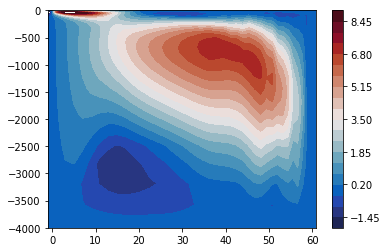

In [7]:
vmax = 9
vmin = -2
levels = np.linspace(vmin, vmax, 21)

moc = compute_moc(vo_to, grid_to, X='X', Z='Z')
ctf = plt.contourf(
    ds.gphiv.isel({'x_c':0}),
    -ds.gdepw_1d,
    moc.isel({'t':-1}),
    levels=levels,
    cmap=cm.cm.balance
)
plt.colorbar(ctf)